# 量子近似优化算法


`Linux` `CPU` `全流程` `初级` `中级` `高级`

[![](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/_static/logo_source.png)](https://gitee.com/mindspore/mindquantum/blob/master/tutorials/quantum_approximate_optimization_algorithm.ipynb)

## 概述

量子近似优化算法（Quantum Approximate Optimization Algorithm，QAOA）是利用量子计算机来近似解决组合优化问题的量子算法，最早由Farhi等人于2014年提出。在本教程里，我们将利用QAOA算法来解决最大割问题（Max-Cut），来熟悉MindQuantum中量子线路的搭建和训练。

> 本文档适用于CPU环境。   
> 你可以在这里找到完整的可运行的样例代码：<https://gitee.com/mindspore/mindquantum/blob/master/tutorials/source/quantum_approximate_optimization_algorithm.py>。

## 环境准备

本教程所需要的额外库：

- networkx

> `networkx`是创建、操作和研究复杂网络的结构、动态和功能库。可通过`pip3 install networkx`来进行安装。

## Max-Cut问题描述

Max-Cut问题是图论中的一个NP-complete问题，它需要将一个图中的顶点分成两部分，并使得两部分被切割的边最多。如下图（a），一个图由五个顶点构成，相互连接的边为```(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (0, 4)```。为了使得被切割的边最多，我们尝试通过（b）图的分割，将1、2、4分为一组，0、3分成另一组，因此可得到被切割的边有5条。当图中顶点增多时，我们很难找到有效的经典算法来解决Max-Cut问题。下面，我们介绍怎么将Max-Cut问题转化为一个哈密顿量的基态能力求解问题。

![max cut](./images/Max_Cut.png)

## Max-Cut问题量子化

这里我们将图中的每个顶点赋予一个量子比特，当顶点被分到左边时，我们将该顶点上的量子比特设置为$\left|0\right>$态，同理，右边为$\left|1\right>$态，当两个顶点被分到不同的集合中时，这两个顶点上的比特将处于不同的量子态。例如对于第0个顶点和第1个顶点，当其连线被切割是，两个顶点上的比特对应的量子态可以为$\left|\psi\right>=\left|0_11_0\right>$或$\left|\psi\right>=\left|1_10_0\right>$，其中下角标表示顶点的序号。此时，我们选择哈密顿量$H=(Z_1Z_0-1)/2$，不难发现：
$$\left<\psi\right|H\left|\psi\right>=-1$$
而当顶点被分到同一集合中是，不难验证此时：
$$\left<\psi\right|H\left|\psi\right>=0$$
因此，我们只用按照上面的规则，写出图对应的哈密顿量$H$，利用量子计算机求得$H$的基态能量与基态，我们就可以得到该图的Max-Cut切割方案与最大切割边数。我们记所有边的集合为$C$，所有边个数为$c$，则哈密顿量可写为：
$$H=\sum_{(i,j)\in C}(Z_iZ_j-1)/2$$

## 导入相关依赖

In [1]:
from mindquantum import Circuit, Hamiltonian, UN, H,ZZ,RX,StateEvolution
from mindquantum.nn import MindQuantumAnsatzOnlyLayer
from mindquantum.ops import QubitOperator
import networkx as nx
import mindspore.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## 搭建所需求解的图

通过`add_path`可在图中添加边。最后画出图的结构。

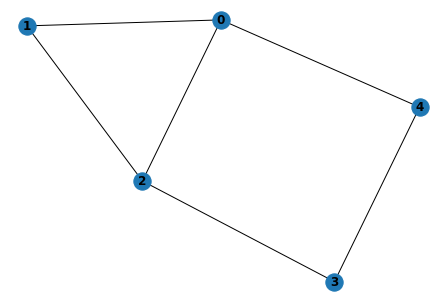

In [2]:
g=nx.Graph()
nx.add_path(g,[0,1])
nx.add_path(g,[1,2])
nx.add_path(g,[2,3])
nx.add_path(g,[3,4])
nx.add_path(g,[0,4])
nx.add_path(g,[0,2])
nx.draw(g,with_labels=True,font_weight='bold')

如上如，我们得到一个由5个节点和6条边构成的图结构。

## 搭建QAOA量子线路

### 线路搭建

这里我们采用量子绝热近似算法，经过演化将量子态从$X^{\otimes n}$的本征态演化到图多应哈密的量的基态。

搭建图对应哈密顿量的含时演化线路：

In [3]:
def build_hc(g,para):
    hc=Circuit()
    for i in g.edges:
        hc+=ZZ(para).on(i)
    return hc

搭建$X^{\otimes n}$含时演化的量子线路：

In [4]:

def build_hb(g,para):
    hc=Circuit()
    for i in g.nodes:
        hc+=RX(para).on(i)
    return hc

为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络

In [5]:
def build_ansatz(g,p):
    c=Circuit()
    for i in range(p):
        c+=build_hc(g,f'g{i}')
        c+=build_hb(g,f'b{i}')
    return c

构建图对应的哈密顿量：

In [6]:
def build_ham(g):
    hc=QubitOperator()
    for i in g.edges:
        hc+=QubitOperator(f'Z{i[0]} Z{i[1]}')
    return hc

生成完整的量子线路和图所对应的哈密顿量：

In [7]:
p=4
ham = Hamiltonian(build_ham(g))
ansatz = build_ansatz(g,p)
init_state_circ = UN(H, g.nodes)

### 搭建待训练量子神经网络

由于该问题不需要编码层量子线路，我们这里使用`MindQuantumAnsatzOnlyLayer`作为待训练的量子神经网络，并采用`Adam`优化器。

In [8]:
net = MindQuantumAnsatzOnlyLayer(ansatz.para_name, init_state_circ+ansatz,ham)
opti = nn.Adam(net.trainable_params(),learning_rate=0.05)
train_net = nn.TrainOneStepCell(net, opti)

## 训练并展示结果

In [9]:
for i in range(600):
    if i%10 == 0:
        print("train step:", i, ", cut:", (len(g.edges)-train_net())/2)

train step: 0 , cut: [[2.9973073]]
train step: 10 , cut: [[2.9218004]]
train step: 20 , cut: [[3.0982673]]
train step: 30 , cut: [[3.2962015]]
train step: 40 , cut: [[3.5924678]]
train step: 50 , cut: [[3.7978523]]
train step: 60 , cut: [[3.9033492]]
train step: 70 , cut: [[4.039832]]
train step: 80 , cut: [[4.1737995]]
train step: 90 , cut: [[4.2354712]]
train step: 100 , cut: [[4.2126665]]
train step: 110 , cut: [[4.168912]]
train step: 120 , cut: [[4.160794]]
train step: 130 , cut: [[4.194193]]
train step: 140 , cut: [[4.2488093]]
train step: 150 , cut: [[4.3062468]]
train step: 160 , cut: [[4.3696184]]
train step: 170 , cut: [[4.4574666]]
train step: 180 , cut: [[4.5727634]]
train step: 190 , cut: [[4.6813583]]
train step: 200 , cut: [[4.7236443]]
train step: 210 , cut: [[4.6782722]]
train step: 220 , cut: [[4.609467]]
train step: 230 , cut: [[4.5821743]]
train step: 240 , cut: [[4.6051164]]
train step: 250 , cut: [[4.656999]]
train step: 260 , cut: [[4.7095237]]
train step: 270 , 

In [10]:
pr = dict(zip(ansatz.para_name,net.weight.asnumpy()))

### 量子态展示

前面我们通过训练得到了量子线路中参数的最优值，下面，我们通过`StateEvolution`函数来输出量子线路在最优参数时的量子态。

In [11]:
print(StateEvolution(init_state_circ+ansatz).final_state(pr,ket=True))

(0.014932050369679928-0.012857728637754917j)¦00000⟩
(-0.03589266911149025-0.005209340248256922j)¦00001⟩
(0.009132038801908493+0.021433578804135323j)¦00010⟩
(-0.014747420325875282-0.019219255074858665j)¦00011⟩
(-0.03589266911149025-0.005209340248256922j)¦00100⟩
(0.06732916086912155+0.11755644530057907j)¦00101⟩
(-0.014747420325875282-0.019219255074858665j)¦00110⟩
(-0.017055170610547066+0.004714870825409889j)¦00111⟩
(0.013924016617238522-0.010388948954641819j)¦01000⟩
(-0.4670667052268982-0.12743939459323883j)¦01001⟩
(-0.013904518447816372+0.05405424162745476j)¦01010⟩
(-0.4670667052268982-0.12743939459323883j)¦01011⟩
(-0.02131757326424122+0.005975773092359304j)¦01100⟩
(-0.013904518447816372+0.05405424162745476j)¦01101⟩
(-0.02131757326424122+0.005975773092359304j)¦01110⟩
(0.013924016617238522-0.010388948954641819j)¦01111⟩
(0.013924016617238522-0.010388948954641819j)¦10000⟩
(-0.02131757326424122+0.005975773092359304j)¦10001⟩
(-0.013904518447816372+0.05405424162745476j)¦10010⟩
(-0.02131757326

### 概率图

我们画出最终量子态在计算基矢下的概率分布

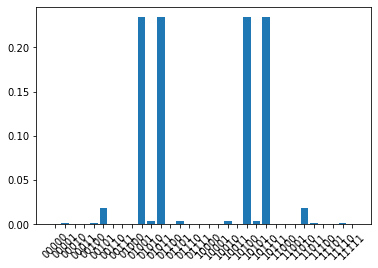

In [12]:
def show_amp(state):
    amp = np.abs(state)**2
    n_qubits = int(np.log2(len(amp)))
    labels = [bin(i)[2:].zfill(n_qubits) for i in range(len(amp))]
    plt.bar(labels, amp)
    plt.xticks(rotation=45)
    plt.show()
state = StateEvolution(init_state_circ+ansatz).final_state(pr)
show_amp(state)

## 总结

这里我们通过量子近似优化算法来解决了Max-Cut问题，并得到了案例中的图对应的最大切割方案。

## 参考文献

[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)